In [86]:
!pip install scikit-uplift xgboost lightgbm causalml duecredit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 13.0 MB/s eta 0:00:00


## Тема: Модели прироста отклика

Задание:

1. Загрузить и изучить датасет
2. Провести EDA: проверить баланс групп, распределение признаков
3. Реализовать 2-3 подхода к uplift-моделированию (например: две модели, единая модель, деревья прироста)
4. Оценить качество моделей с помощью метрик: AUQC, Uplift@K, децильный анализ
5. Выделить сегменты клиентов: убеждаемые, уверенные, равнодушные, антагонисты
6. Откомментировать код

In [123]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

# Библиотеки для uplift modeling
from sklift.datasets import fetch_x5
from sklift.models import SoloModel, ClassTransformation, TwoModels
from sklift.metrics import (
    uplift_auc_score,
    qini_auc_score,
    uplift_curve,
    qini_curve,
    perfect_uplift_curve,
    perfect_qini_curve,
)


# ML модели
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Настройки визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
filterwarnings('ignore')

### Загрузка

In [3]:
dataset = fetch_x5()

train = dataset.data['train']
clients = dataset.data['clients'] 
purchases = dataset.data['purchases']
target = dataset.target
treatment = dataset.treatment

print("Структура данных:")
print(f"Train shape: {train.shape}")
print(f"Clients shape: {clients.shape}")
print(f"Purchases shape: {purchases.shape}")
print(f"Target shape: {target.shape}")
print(f"Treatment shape: {treatment.shape}")

Part 1: X5 train:   0%|          | 0.00/1.18M [00:00<?, ?iB/s]

Part 2: X5 clients:   0%|          | 0.00/7.64M [00:00<?, ?iB/s]

Part 3: X5 purchases:   0%|          | 0.00/670M [00:00<?, ?iB/s]

Структура данных:
Train shape: (200039, 1)
Clients shape: (400162, 5)
Purchases shape: (45786568, 13)
Target shape: (200039,)
Treatment shape: (200039,)


`fetch_x5()` возвращает:
- `dataset.data.train` — таблица с `client_id` (строки соответствуют target/treatment)
- `dataset.target` — целевое действие (0/1)
- `dataset.treatment` — индикатор воздействия (0/1)
- `dataset.data.clients` — признаки клиентов
- `dataset.data.purchases` — история покупок до коммуникации (агрегируем)

In [4]:
# Объединяем данные для анализа
train_full = train.copy()
train_full['treatment'] = treatment.values
train_full['target'] = target.values

print("\nПервые строки train_full:")
print(train_full.head())
print(f"\nРазмер: {train_full.shape}")


Первые строки train_full:
    client_id  treatment  target
0  000012768d          0       1
1  000036f903          1       1
2  00010925a5          1       1
3  0001f552b0          1       1
4  00020e7b18          1       1

Размер: (200039, 3)


treatment
0 = контрольная группа (клиент НЕ получал маркетингового воздействия)

1 = экспериментальная группа (клиент получил маркетинговое воздействие)

### Информация о клиентах

In [7]:
print("Информация о клиентах:")
print(clients.info())
print("\nПервые строки:")
print(clients.head())

Информация о клиентах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400162 entries, 0 to 400161
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   client_id          400162 non-null  object
 1   first_issue_date   400162 non-null  object
 2   first_redeem_date  364693 non-null  object
 3   age                400162 non-null  int64 
 4   gender             400162 non-null  object
dtypes: int64(1), object(4)
memory usage: 15.3+ MB
None

Первые строки:
    client_id     first_issue_date    first_redeem_date  age gender
0  000012768d  2017-08-05 15:40:48  2018-01-04 19:30:07   45      U
1  000036f903  2017-04-10 13:54:23  2017-04-23 12:37:56   72      F
2  000048b7a6  2018-12-15 13:33:11                  NaN   68      F
3  000073194a  2017-05-23 12:56:14  2017-11-24 11:18:01   60      F
4  00007c7133  2017-05-22 16:17:08  2018-12-31 17:17:33   67      U


### Информация о покупках

In [8]:
print("Информация о покупках:")
print(purchases.info())
print("\nПервые строки:")
print(purchases.head(5))

Информация о покупках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   client_id                object 
 1   transaction_id           object 
 2   transaction_datetime     object 
 3   regular_points_received  float64
 4   express_points_received  float64
 5   regular_points_spent     float64
 6   express_points_spent     float64
 7   purchase_sum             float64
 8   store_id                 object 
 9   product_id               object 
 10  product_quantity         float64
 11  trn_sum_from_iss         float64
 12  trn_sum_from_red         float64
dtypes: float64(8), object(5)
memory usage: 4.4+ GB
None

Первые строки:
    client_id transaction_id transaction_datetime  regular_points_received  \
0  000012768d     7e3e2e3984  2018-12-01 07:12:45                     10.0   
1  000012768d     7e3e2e3984  2018-12-01 07:12:45              

### EDA

### График 1: Распределение treatment

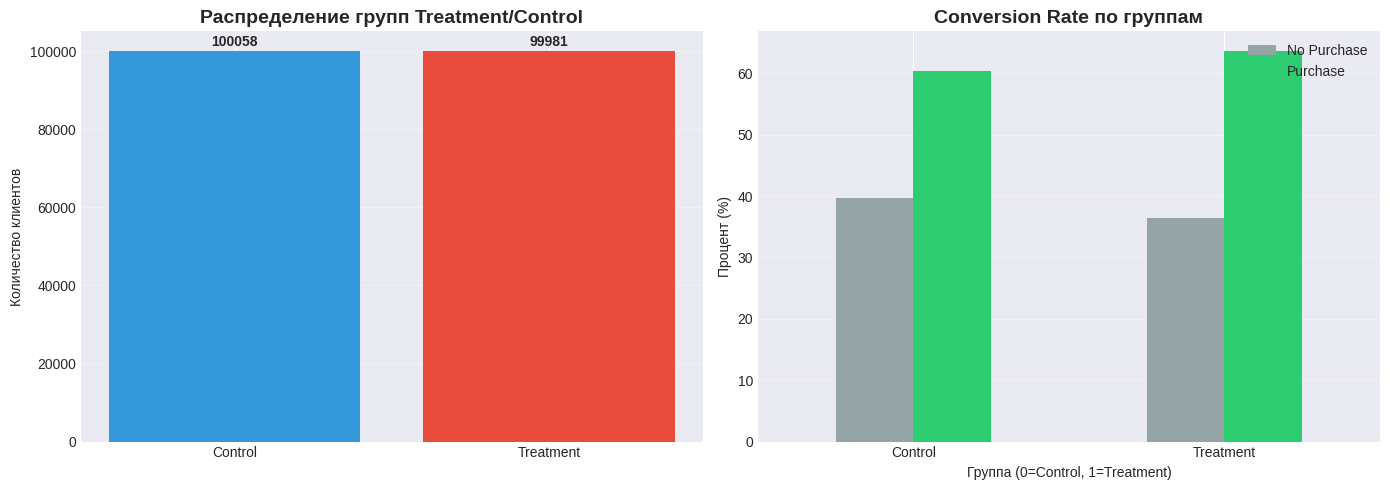

In [12]:
# Проверяем баланс между treatment и control группами
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Распределение treatment
treatment_counts = train_full['treatment'].value_counts()
axes[0].bar(['Control', 'Treatment'], treatment_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Распределение групп Treatment/Control', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Количество клиентов')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(treatment_counts.values):
    axes[0].text(i, v + 500, str(v), ha='center', va='bottom', fontweight='bold')

# График 2: Распределение target в группах
target_by_treatment = pd.crosstab(train_full['treatment'], train_full['target'], normalize='index') * 100
target_by_treatment.plot(kind='bar', ax=axes[1], color=['#95a5a6', '#2ecc71'])
axes[1].set_title('Conversion Rate по группам', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Группа (0=Control, 1=Treatment)')
axes[1].set_ylabel('Процент (%)')
axes[1].set_xticklabels(['Control', 'Treatment'], rotation=0)
axes[1].legend(['No Purchase', 'Purchase'], loc='upper right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Статистика
print("Статистика по группам:")
print(f"Control группа: {treatment_counts[0]} клиентов ({treatment_counts[0]/len(train_full)*100:.1f}%)")
print(f"Treatment группа: {treatment_counts[1]} клиентов ({treatment_counts[1]/len(train_full)*100:.1f}%)")
print(f"\nConversion Rate:")
print(f"Control: {train_full[train_full['treatment']==0]['target'].mean()*100:.2f}%")
print(f"Treatment: {train_full[train_full['treatment']==1]['target'].mean()*100:.2f}%")
print(f"Naive Uplift: {(train_full[train_full['treatment']==1]['target'].mean() - train_full[train_full['treatment']==0]['target'].mean())*100:.2f}%")

Статистика по группам:
Control группа: 100058 клиентов (50.0%)
Treatment группа: 99981 клиентов (50.0%)

Conversion Rate:
Control: 60.33%
Treatment: 63.65%
Naive Uplift: 3.32%


Конверсия (Conversion Rate, CR) — это доля клиентов, которые совершили целевое действие.
conversion rate = (количество клиентов с target = 1) / (общее число клиентов)
Конверсия 60% означает, что 60 из 100 клиентов совершили целевое действие.

Статистика по группам показывает корректно проведённый эксперимент.
Контрольная и целевая группы практически равны по размеру (≈50% / 50%), что соответствует хорошему A/B-дизайну и снижает риск систематического смещения результатов.

Средняя конверсия в контрольной группе составляет 60.33%, тогда как в группе с воздействием — 63.65%. Разница между ними равна 3.32 процентных пункта, что можно интерпретировать как наивный uplift — средний эффект маркетингового воздействия на всей выборке.

Однако данный показатель отражает агрегированный эффект и не учитывает тип клиентов. 


#### Анализ признаков клиентов

ДЕТАЛЬНЫЙ АНАЛИЗ ВОЗРАСТА
count    400162.000000
mean         46.488112
std          43.871218
min       -7491.000000
25%          34.000000
50%          45.000000
75%          59.000000
max        1901.000000
Name: age, dtype: float64

Минимальный возраст: -7491
Максимальный возраст: 1901
Количество отрицательных значений: 96
Количество значений > 100: 1049
Пропуски: 0


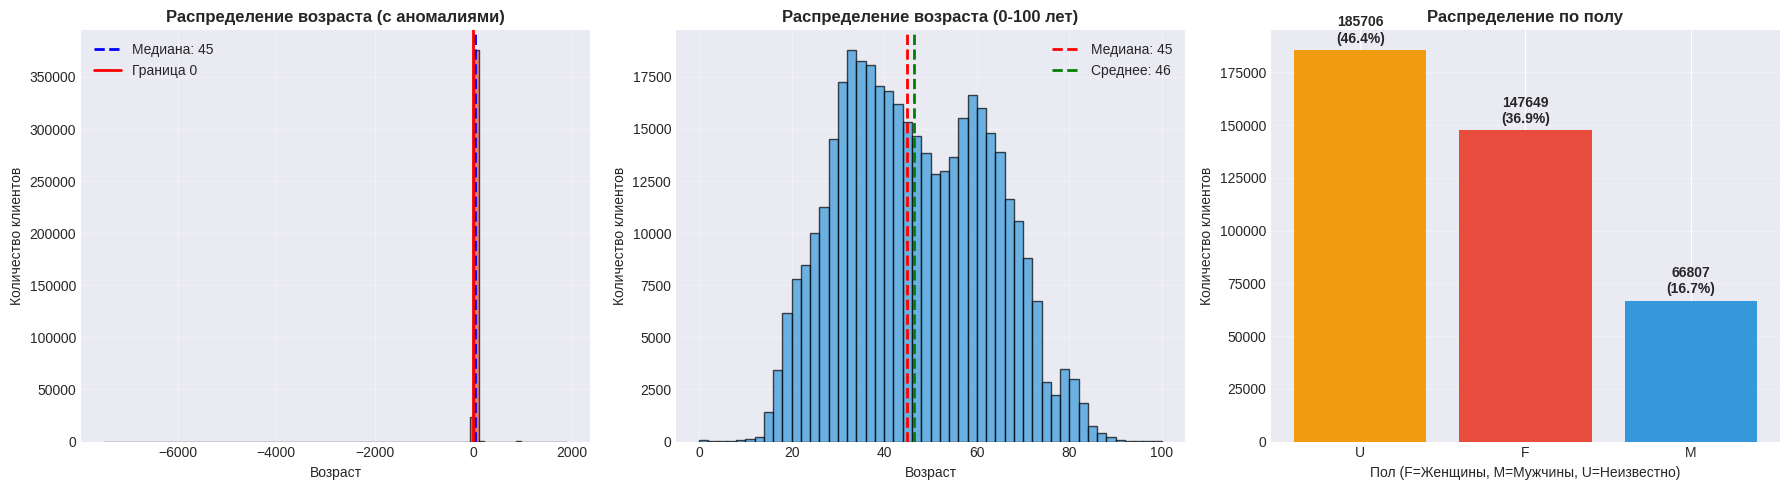

СТАТИСТИКА ПО ПОЛУ
gender
U    185706
F    147649
M     66807
Name: count, dtype: int64

Процентное распределение:
gender
U    46.407705
F    36.897307
M    16.694989
Name: proportion, dtype: float64


In [26]:
# Изучаем распределение возраста и пола
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Статистика возраста
print("ДЕТАЛЬНЫЙ АНАЛИЗ ВОЗРАСТА")
print(clients['age'].describe())
print(f"\nМинимальный возраст: {clients['age'].min()}")
print(f"Максимальный возраст: {clients['age'].max()}")
print(f"Количество отрицательных значений: {(clients['age'] < 0).sum()}")
print(f"Количество значений > 100: {(clients['age'] > 100).sum()}")
print(f"Пропуски: {clients['age'].isnull().sum()}")

# График 1: Полное распределение возраста (с аномалиями)
axes[0].hist(clients['age'].dropna(), bins=100, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0].set_title('Распределение возраста (с аномалиями)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Возраст')
axes[0].set_ylabel('Количество клиентов')
axes[0].axvline(clients['age'].median(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Медиана: {clients["age"].median():.0f}')
axes[0].axvline(0, color='red', linestyle='-', linewidth=2, label='Граница 0')
axes[0].legend()
axes[0].grid(alpha=0.3)

# График 2: Разумные значения возраста (от 0 до 100)
age_valid = clients['age'][(clients['age'] >= 0) & (clients['age'] <= 100)]
axes[1].hist(age_valid, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].set_title('Распределение возраста (0-100 лет)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Возраст')
axes[1].set_ylabel('Количество клиентов')
axes[1].axvline(age_valid.median(), color='red', linestyle='--', linewidth=2, 
                   label=f'Медиана: {age_valid.median():.0f}')
axes[1].axvline(age_valid.mean(), color='green', linestyle='--', linewidth=2,
                   label=f'Среднее: {age_valid.mean():.0f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

# График 3: Распределение пола
gender_counts = clients['gender'].value_counts()
colors_gender = ['#f39c12', '#e74c3c', '#3498db']
axes[2].bar(gender_counts.index, gender_counts.values, color=colors_gender)
axes[2].set_title('Распределение по полу', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Пол (F=Женщины, M=Мужчины, U=Неизвестно)')
axes[2].set_ylabel('Количество клиентов')
axes[2].grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for i, (idx, val) in enumerate(gender_counts.items()):
    axes[2].text(i, val + 2000, f'{val}\n({val/len(clients)*100:.1f}%)', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("СТАТИСТИКА ПО ПОЛУ")
print(clients['gender'].value_counts())
print(f"\nПроцентное распределение:")
print(clients['gender'].value_counts(normalize=True) * 100)

### Агрегация и анализ покупок

In [20]:
# Агрегируем историю покупок по клиентам
purchases_agg = purchases.groupby('client_id').agg({
    'transaction_id': 'nunique',              # Количество транзакций
    'purchase_sum': ['sum', 'mean', 'std'],   # Статистики по сумме
    'product_id': 'nunique',                  # Уникальных товаров
    'product_quantity': 'sum',                # Общее количество товаров
    'regular_points_received': 'sum',         # Накопленные баллы
    'store_id': 'nunique'                     # Количество магазинов
}).reset_index()

In [21]:
# Упрощаем названия колонок
purchases_agg.columns = [
    'client_id', 'num_transactions', 'total_purchase_sum', 
    'avg_purchase_sum', 'std_purchase_sum', 'num_unique_products',
    'total_quantity', 'total_points', 'num_stores'
]

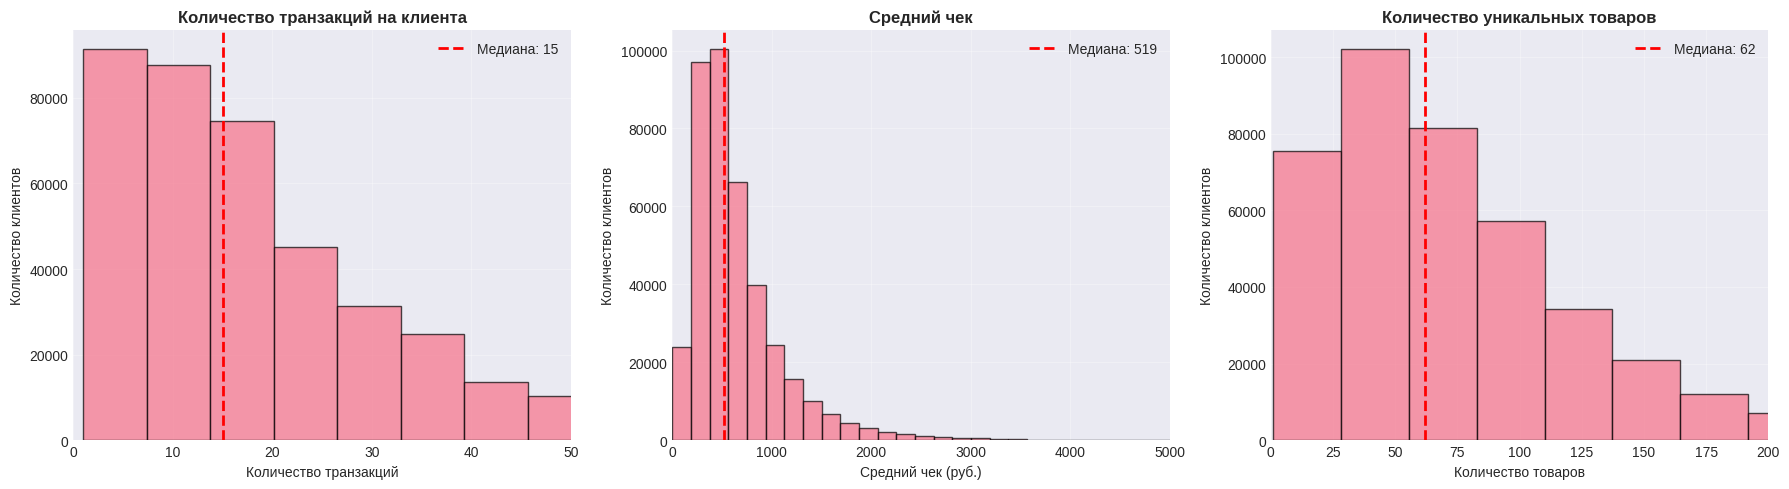

In [27]:
# Визуализация ключевых метрик покупок (3 графика в одну строку)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Количество транзакций
axes[0].hist(
    purchases_agg['num_transactions'],
    bins=50,
    alpha=0.7,
    edgecolor='black'
)
axes[0].set_title('Количество транзакций на клиента', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Количество транзакций')
axes[0].set_ylabel('Количество клиентов')
axes[0].set_xlim(0, 50)
axes[0].axvline(
    purchases_agg['num_transactions'].median(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Медиана: {purchases_agg["num_transactions"].median():.0f}'
)
axes[0].legend()
axes[0].grid(alpha=0.3)

# График 2: Средний чек
axes[1].hist(
    purchases_agg['avg_purchase_sum'],
    bins=50,
    alpha=0.7,
    edgecolor='black'
)
axes[1].set_title('Средний чек', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Средний чек (руб.)')
axes[1].set_ylabel('Количество клиентов')
axes[1].set_xlim(0, 5000)
axes[1].axvline(
    purchases_agg['avg_purchase_sum'].median(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Медиана: {purchases_agg["avg_purchase_sum"].median():.0f}'
)
axes[1].legend()
axes[1].grid(alpha=0.3)

# График 3: Количество уникальных товаров
axes[2].hist(
    purchases_agg['num_unique_products'],
    bins=50,
    alpha=0.7,
    edgecolor='black'
)
axes[2].set_title('Количество уникальных товаров', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Количество товаров')
axes[2].set_ylabel('Количество клиентов')
axes[2].set_xlim(0, 200)
axes[2].axvline(
    purchases_agg['num_unique_products'].median(),
    color='red',
    linestyle='--',
    linewidth=2,
    label=f'Медиана: {purchases_agg["num_unique_products"].median():.0f}'
)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### Объединение и очистка данных

In [28]:
# Объединяем train с clients
data = train_full.merge(clients, on='client_id', how='left')
print(f"После объединения с clients: {data.shape}")

# Объединяем с агрегированными покупками
data = data.merge(purchases_agg, on='client_id', how='left')
print(f"После объединения с purchases: {data.shape}")

# Заполняем пропуски для клиентов без покупок
purchase_cols = ['num_transactions', 'total_purchase_sum', 'avg_purchase_sum', 
                 'std_purchase_sum', 'num_unique_products', 'total_quantity', 
                 'total_points', 'num_stores']
data[purchase_cols] = data[purchase_cols].fillna(0)

print(f"\nДанные объединены")
print(f"\nПропуски после заполнения:")
print(data.isnull().sum()[data.isnull().sum() > 0])

После объединения с clients: (200039, 7)
После объединения с purchases: (200039, 15)

Данные объединены

Пропуски после заполнения:
first_redeem_date    17546
dtype: int64


first_redeem_date = 0 - Клиенты, которые не использовали купон

In [29]:
print(f"Размер до проверки дубликатов: {data.shape}")
print(f"Количество дубликатов по client_id: {data.duplicated(subset=['client_id']).sum()}")

Размер до проверки дубликатов: (200039, 15)
Количество дубликатов по client_id: 0


Что делаем:
1. Обрабатываем аномалии в возрасте (заменяем на медиану)
2. Кодируем пол (F=1, M=2, U=0)
3. Создаём признак использования купона
4. Создаём дополнительные признаки (средний размер корзины, частота покупок)
5. Создаём индикаторы VIP-клиентов (выбросы по покупкам)

In [52]:
# Обработка аномалий в возрасте
print(f"\nОБРАБОТКА ВОЗРАСТА:")
print(f"   До обработки: min={data['age'].min():.0f}, max={data['age'].max():.0f}")
print(f"   Отрицательные: {(data['age'] < 0).sum()}, Больше 100: {(data['age'] > 100).sum()}")


1. ОБРАБОТКА ВОЗРАСТА:
   До обработки: min=1, max=98
   Отрицательные: 0, Больше 100: 0


In [44]:
# Вычисляем медиану по разумным значениям
age_median = data['age'][(data['age'] > 0) & (data['age'] < 100)].median()

# Заменяем аномалии
data.loc[(data['age'] <= 0) | (data['age'] >= 100) | (data['age'].isnull()), 'age'] = age_median

In [45]:
print(f"   После обработки: min={data['age'].min():.0f}, max={data['age'].max():.0f}")
print(f"   Аномалии заменены на медиану ({age_median:.0f} лет)")

   После обработки: min=1, max=98
   Аномалии заменены на медиану (45 лет)


In [46]:
# Кодирование пола
print(f"\nКОДИРОВАНИЕ ПОЛА:")
print(f"   Схема: F=1, M=2, U=0 (Unknown)")
data['gender_encoded'] = data['gender'].map({'F': 1, 'M': 2, 'U': 0}).fillna(0).astype(int)
print(f"   Признак gender_encoded создан")
print(f"   Распределение: {data['gender_encoded'].value_counts().to_dict()}")


КОДИРОВАНИЕ ПОЛА:
   Схема: F=1, M=2, U=0 (Unknown)
   Признак gender_encoded создан
   Распределение: {0: 92832, 1: 73696, 2: 33511}


In [53]:
print("\nКУПОНЫ:")
if 'first_redeem_date' in data.columns:
    data['coupon_used'] = (~data['first_redeem_date'].isnull()).astype(int)
    used = data['coupon_used'].sum()
    print(f"  Использовали купон: {used:,} ({used/len(data)*100:.1f}%)")
    print(f"  Корреляция с target: {data[['coupon_used', 'target']].corr().iloc[0,1]:.4f}")
else:
    data['coupon_used'] = 0



КУПОНЫ:
  Использовали купон: 182,493 (91.2%)
  Корреляция с target: 0.1634


In [54]:
data['coupon_purchase_interaction'] = data['coupon_used'] * data['has_purchases']

In [47]:
# Создание дополнительных признаков
print(f"\nНОВЫЕ ПРИЗНАКИ:")
data['has_purchases'] = (data['num_transactions'] > 0).astype(int)
#avg_basket_size = среднее количество товаров в одной покупке
data['avg_basket_size'] = data['total_quantity'] / (data['num_transactions'] + 1)
# avg_product_price = средняя цена одного товара в покупках клиента
data['avg_product_price'] = data['total_purchase_sum'] / (data['total_quantity'] + 1)

# насколько регулярно клиент совершает покупки
data['purchase_frequency'] = data['num_transactions'] / (data['num_stores'] + 1)
# среднее количество бонусных баллов, начисляемых клиенту за одну покупку
data['points_per_purchase'] = data['total_points'] / (data['num_transactions'] + 1)

print(f"   has_purchases - индикатор покупок")
print(f"   avg_basket_size - средний размер корзины")
print(f"   avg_product_price - средняя цена товара")
print(f"   purchase_frequency - частота покупок")
print(f"   points_per_purchase - баллов на покупку")


НОВЫЕ ПРИЗНАКИ:
   has_purchases - индикатор покупок
   avg_basket_size - средний размер корзины
   avg_product_price - средняя цена товара
   purchase_frequency - частота покупок на магазин
   points_per_purchase - баллов на покупку


IQR (Interquartile Range, межквартильный размах) — это статистическая мера разброса данных, основанная на квартилях распределения.

Обозначения:

Q1 — 25-й перцентиль (нижний квартиль)

Q3 — 75-й перцентиль (верхний квартиль)

IQR = Q3 − Q1

IQR описывает “центральную” часть распределения, где находится 50% наблюдений, и устойчив к выбросам.

In [55]:
print("\nVIP-КЛИЕНТЫ (индикаторы выбросов):")
print(f"  Метод: IQR с множителем 3 (только экстремальные значения)")

outlier_cols = ['total_purchase_sum', 'avg_purchase_sum', 'num_transactions']
for col in outlier_cols:
    q1, q3 = data[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + 3 * iqr
    
    outlier_col = f'is_{col}_outlier'
    data[outlier_col] = (data[col] > upper).astype(int)
    outliers_count = data[outlier_col].sum()
    
    print(f"  {col}:")
    print(f"    Порог: >{upper:.0f}")
    print(f"    VIP-клиентов: {outliers_count} ({outliers_count/len(data)*100:.2f}%)")

# VIP статистика
vip_mask = (data['is_total_purchase_sum_outlier'] == 1) | \
           (data['is_avg_purchase_sum_outlier'] == 1) | \
           (data['is_num_transactions_outlier'] == 1)

vip_count = vip_mask.sum()
vip_revenue = data[vip_mask]['total_purchase_sum'].sum()
total_revenue = data['total_purchase_sum'].sum()

print(f"\n  ИТОГО VIP-клиентов: {vip_count} ({vip_count/len(data)*100:.2f}%)")
print(f"  Их доля в выручке: {vip_revenue/total_revenue*100:.1f}%")
print(f"\n  Примечание: {vip_count/len(data)*100:.0f}% клиентов дают {vip_revenue/total_revenue*100:.0f}% выручки")
print(f"  Эти клиенты могут иметь особый uplift-паттерн")
print(f"  Индикаторы выбросов помогут модели учесть их специфику")



VIP-КЛИЕНТЫ (индикаторы выбросов):
  Метод: IQR с множителем 3 (только экстремальные значения)
  total_purchase_sum:
    Порог: >331252
    VIP-клиентов: 9067 (4.53%)
  avg_purchase_sum:
    Порог: >2180
    VIP-клиентов: 3296 (1.65%)
  num_transactions:
    Порог: >84
    VIP-клиентов: 2083 (1.04%)

  ИТОГО VIP-клиентов: 12027 (6.01%)
  Их доля в выручке: 34.0%

  Примечание: 6% клиентов дают 34% выручки
  Эти клиенты могут иметь особый uplift-паттерн
  Индикаторы выбросов помогут модели учесть их специфику


### ВИЗУАЛИЗАЦИЯ НОВЫХ ПРИЗНАКОВ

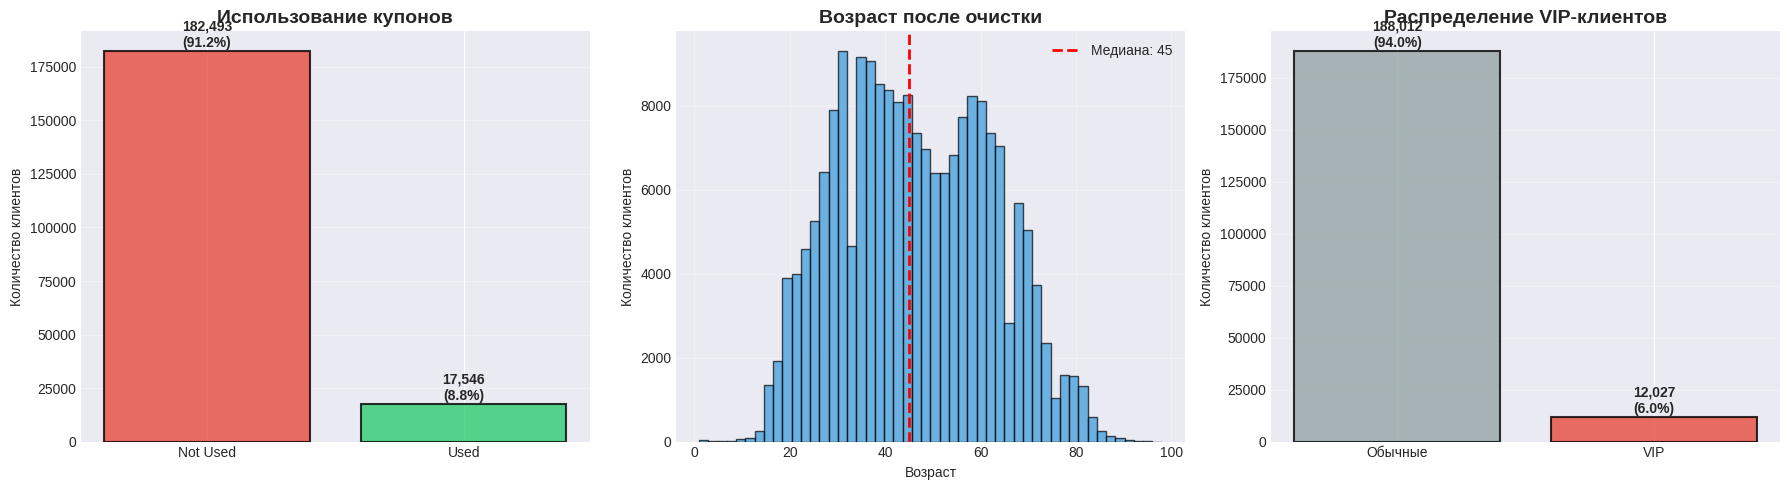

In [56]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График 1: Использование купонов
coupon_counts = data['coupon_used'].value_counts()
axes[0].bar(['Not Used', 'Used'], coupon_counts.values, 
            color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_title('Использование купонов', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Количество клиентов')
axes[0].grid(axis='y', alpha=0.3)

for i, v in enumerate(coupon_counts.values):
    axes[0].text(i, v + 500, f'{v:,}\n({v/len(data)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

# График 2: Возраст после очистки
axes[1].hist(data['age'], bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[1].set_title('Возраст после очистки', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Возраст')
axes[1].set_ylabel('Количество клиентов')
axes[1].axvline(data['age'].median(), color='red', linestyle='--', 
                linewidth=2, label=f'Медиана: {data["age"].median():.0f}')
axes[1].legend()
axes[1].grid(alpha=0.3)

# График 3: VIP vs Обычные клиенты
vip_data = ['Обычные', 'VIP']
vip_values = [(~vip_mask).sum(), vip_mask.sum()]
colors_vip = ['#95a5a6', '#e74c3c']

axes[2].bar(vip_data, vip_values, color=colors_vip, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_title('Распределение VIP-клиентов', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Количество клиентов')
axes[2].grid(axis='y', alpha=0.3)

for i, v in enumerate(vip_values):
    axes[2].text(i, v + 500, f'{v:,}\n({v/len(data)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### Корреляционный анализ

In [57]:
# Выбираем числовые признаки
numeric_features = [
    'age', 'gender_encoded', 'coupon_used',
    'num_transactions', 'total_purchase_sum', 'avg_purchase_sum', 'std_purchase_sum',
    'num_unique_products', 'total_quantity', 'total_points', 'num_stores',
    'has_purchases', 'avg_basket_size', 'avg_product_price',
    'purchase_frequency', 'points_per_purchase', 'coupon_purchase_interaction',
    'is_total_purchase_sum_outlier', 'is_avg_purchase_sum_outlier', 
    'is_num_transactions_outlier', 'treatment', 'target'
]

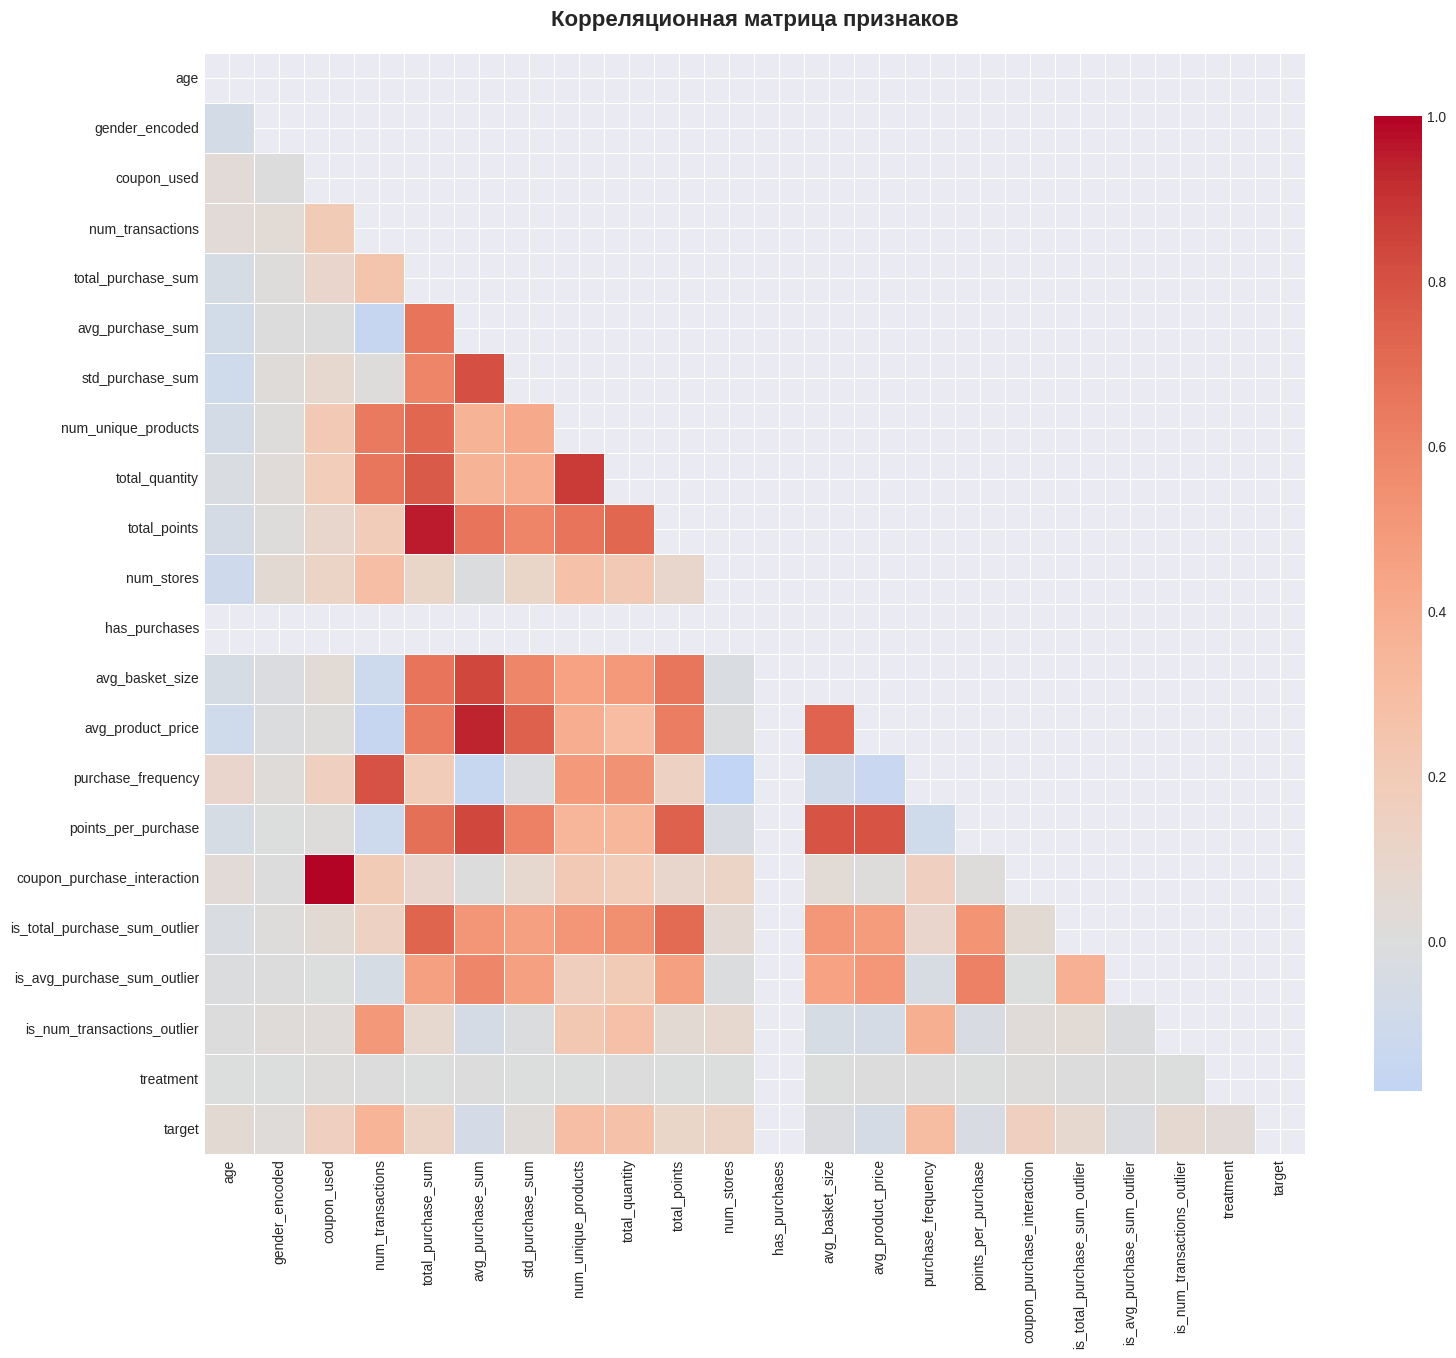

In [58]:
# Вычисляем корреляционную матрицу
corr_matrix = data[numeric_features].corr()

# Визуализация
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [60]:
# Топ корреляций
print("\nТоп-10 признаков по корреляции с TARGET:")
print("-" * 80)
target_corr = corr_matrix['target'].drop('target').sort_values(ascending=False)
for i, (feature, corr) in enumerate(target_corr.head(10).items(), 1):
    print(f"{i:2d}. {feature:35s}: {corr:+.4f}")

print("\nТоп-10 признаков по корреляции с TREATMENT:")
print("-" * 80)
treatment_corr = corr_matrix['treatment'].drop('treatment').abs().sort_values(ascending=False)
for i, (feature, corr) in enumerate(treatment_corr.head(10).items(), 1):
    print(f"{i:2d}. {feature:35s}: {corr:.4f}")



Топ-10 признаков по корреляции с TARGET:
--------------------------------------------------------------------------------
 1. num_transactions                   : +0.3566
 2. purchase_frequency                 : +0.2991
 3. num_unique_products                : +0.2903
 4. total_quantity                     : +0.2725
 5. coupon_used                        : +0.1634
 6. coupon_purchase_interaction        : +0.1634
 7. num_stores                         : +0.1271
 8. total_purchase_sum                 : +0.1256
 9. total_points                       : +0.1063
10. is_total_purchase_sum_outlier      : +0.0742

Топ-10 признаков по корреляции с TREATMENT:
--------------------------------------------------------------------------------
 1. target                             : 0.0342
 2. coupon_used                        : 0.0117
 3. coupon_purchase_interaction        : 0.0117
 4. is_total_purchase_sum_outlier      : 0.0046
 5. num_transactions                   : 0.0037
 6. is_avg_purchase_s

### Низкая корреляция с treatment означает, что эксперимент рандомизирован корректно

## Подготовка данных для моделирования

In [61]:
# Список признаков
feature_cols = [
    # Демография
    'age', 'gender_encoded', 'coupon_used',
    # История покупок
    'num_transactions', 'total_purchase_sum', 'avg_purchase_sum', 'std_purchase_sum',
    'num_unique_products', 'total_quantity', 'total_points', 'num_stores',
    # Созданные признаки
    'has_purchases', 'avg_basket_size', 'avg_product_price',
    'purchase_frequency', 'points_per_purchase', 'coupon_purchase_interaction',
    # Индикаторы VIP
    'is_total_purchase_sum_outlier', 'is_avg_purchase_sum_outlier', 
    'is_num_transactions_outlier'
]

In [62]:
# Формируем матрицы
X = data[feature_cols].copy()
y = data['target'].copy()
treat = data['treatment'].copy()

In [64]:
print(f"  X (признаки):       {X.shape}")
print(f"  y (target):         {y.shape}")
print(f"  treat (treatment):  {treat.shape}")


  X (признаки):       (200039, 20)
  y (target):         (200039,)
  treat (treatment):  (200039,)


In [66]:
print(f"\nБаланс классов:")
print(f"  Target=0 (no purchase): {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")
print(f"  Target=1 (purchase):    {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")
print(f"  Treatment=0 (control):  {(treat==0).sum():,} ({(treat==0).mean()*100:.1f}%)")
print(f"  Treatment=1 (treated):  {(treat==1).sum():,} ({(treat==1).mean()*100:.1f}%)")


Баланс классов:
  Target=0 (no purchase): 76,037 (38.0%)
  Target=1 (purchase):    124,002 (62.0%)
  Treatment=0 (control):  100,058 (50.0%)
  Treatment=1 (treated):  99,981 (50.0%)


## РАЗДЕЛЕНИЕ НА TRAIN/TEST

In [67]:
# Разделяем с сохранением баланса treatment
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X, y, treat, 
    test_size=0.3,      # 30 процентов на тест
    random_state=42,    # Для воспроизводимости
    stratify=treat      # Сохраняем баланс treatment
)

In [68]:
print(f"\nРазмеры наборов:")
print(f"  Train: {X_train.shape}")
print(f"  Test:  {X_test.shape}")



Размеры наборов:
  Train: (140027, 20)
  Test:  (60012, 20)


## Uplift моделирование

Задача: оценить эффект воздействия (treatment) на целевое действие (target)
#для каждого клиента и выделить сегменты по восприимчивости к воздействию.

Три подхода:
1. Две модели (T-learner)
2. Единая модель (S-learner)
3. Деревья прироста

In [143]:
def print_uplift_stats(name: str, u: np.ndarray) -> None:
    """Печатает компактную статистику распределения uplift."""
    print(
        f"{name}:",
        f"mean={u.mean():+.4f},",
        f"median={np.median(u):+.4f},",
        f"std={u.std():.4f},",
        f"min={u.min():+.4f},",
        f"max={u.max():+.4f}",
    )

def evaluate_model(name, uplift, y_true, treatment):
    """Вычисляет метрики качества uplift-модели"""
    uplift = np.asarray(uplift).flatten()
    return {
        "Model": name,
        "AUUC": uplift_auc_score(y_true, uplift, treatment),
        "Qini AUC": qini_auc_score(y_true, uplift, treatment),
        "Uplift@10%": uplift_at_k(y_true, uplift, treatment, strategy="overall", k=0.1),
        "Uplift@30%": uplift_at_k(y_true, uplift, treatment, strategy="overall", k=0.3),
    }

### ПОДХОД 1: Two Models

In [ ]:
# Обучаем 2 отдельные модели вероятности отклика:
#   - p1(x) = P(Y=1 | X=x, T=1) — модель для treatment-группы
#   - p0(x) = P(Y=1 | X=x, T=0) — модель для control-группы
#
# Uplift(x) = p1(x) - p0(x)
#
# Плюсы:
#   - Простой и интуитивный подход
#   - Каждая модель "специализируется" на своей группе
#   - Легко интерпретировать результат
#
# Минусы:
#   - Требует достаточно данных в каждой группе
#   - Модели обучаются независимо — не "видят" разницу между группами
#   - Ошибки двух моделей накапливаются при вычитании

# Параметры CatBoost для обеих моделей
cb_params = dict(
    iterations=300,
    depth=6,
    learning_rate=0.05,
    loss_function="Logloss",
    random_seed=42,
    verbose=False,
)

# Создаём T-learner с двумя CatBoost моделями
tm_model = TwoModels(
    estimator_trmnt=CatBoostClassifier(**cb_params),  # модель для T=1 (treatment)
    estimator_ctrl=CatBoostClassifier(**cb_params),   # модель для T=0 (control)
    method="vanilla",  # uplift = p1(x) - p0(x)
)

# Обучение: модель сама разделит данные по treat_train
tm_model.fit(X_train, y_train, treat_train)

# Предсказание uplift на тестовой выборке
tm_uplift_test = tm_model.predict(X_test)

print_uplift_stats("Two Models (T-learner) с CatBoost", tm_uplift_test)

Two Models (T-learner) с CatBoost: mean=+0.0285, median=+0.0241, std=0.0402, min=-0.4258, max=+0.3377


Uplift = шанс покупки с рассылкой − шанс покупки без рассылки.

mean=+0.0285 → в среднем рассылка повышает шанс покупки примерно на 2.85% (2.85 п.п.)

median=+0.0241 → у половины клиентов эффект около +2.5% или больше

std=0.0402 → эффект сильно отличается у разных людей (кто-то реагирует, кто-то нет)

min=-0.4258 → есть клиенты, кому рассылка вредит (шанс покупки падает до −43%) — им лучше не слать

max=+0.3377 → есть клиенты, кому рассылка очень помогает (до +33%) — их выгодно таргетировать

### ПОДХОД 2: ЕДИНАЯ МОДЕЛЬ (Class Transformation / S-learner)

In [ ]:
# Вместо двух моделей обучаем ОДНУ на трансформированных метках.
# 
# Трансформация Джасковски (Jaskowski):
#   Z = Y*T + (1-Y)*(1-T)
#   с весами, пропорциональными P(T) и P(1-T)
#
# Модель предсказывает сразу uplift, без явного вычисления p1-p0.
#
# Плюсы:
#   - Использует ВСЕ данные в одной модели (больше обучающих примеров)
#   - Мощный базовый алгоритм (CatBoost) улучшает качество
#   - Модель "видит" обе группы одновременно
#
# Минусы:
#   - Менее интуитивно, чем T-learner
#   - Качество зависит от корректности трансформации меток

# Используем CatBoost как базовый алгоритм для лучшего качества
ct_model = ClassTransformation(
    estimator=CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.05,
        loss_function="Logloss",
        random_seed=42,
        verbose=False
    )
)

# Обучение на трансформированных метках
ct_model.fit(X_train, y_train, treat_train)

# Предсказание uplift
ct_uplift_test = ct_model.predict(X_test)

print_uplift_stats("Class Transformation (S-learner) с CatBoost", ct_uplift_test)

Class Transformation (S-learner) с CatBoost: mean=+0.0302, median=+0.0285, std=0.0402, min=-0.5293, max=+0.4220


### ПОДХОД 3: ДЕРЕВЬЯ ПРИРОСТА (Uplift Random Forest)

In [ ]:
# Дерево выбирает разбиения НЕ по чистоте классов (как обычное дерево),
# а по максимизации РАЗНИЦЫ отклика между treatment и control в листьях.
#
# Критерии разбиения:
#   - KL-divergence (Kullback-Leibler) — расхождение распределений
#   - Chi-squared — статистический критерий
#   - Euclidean distance — евклидово расстояние
#
# Плюсы:
#   - Интерпретируемость: листья = сегменты клиентов
#   - Напрямую оптимизирует uplift (а не отклик)
#   - Можно извлечь правила сегментации
#
# Минусы:
#   - Одно дерево нестабильно → используем лес (Random Forest)
#   - Требует настройки гиперпараметров

# causalml ожидает строковые метки групп
treat_train_str = np.where(treat_train == 0, "control", "treatment")
treat_test_str = np.where(treat_test == 0, "control", "treatment")

# Создаём Uplift Random Forest
urf_model = UpliftRandomForestClassifier(
    control_name="control",      # название control-группы
    n_estimators=200,            # количество деревьев в лесу
    max_depth=5,                 # максимальная глубина деревьев
    min_samples_leaf=200,        # мин. объектов в листе (регуляризация)
    random_state=42,
    evaluationFunction="KL",     # критерий разбиения: KL-divergence
)

urf_model.fit(
    X_train.values, 
    treatment=treat_train_str, 
    y=y_train.values
)

# Предсказание: возвращает словарь {'treatment': uplift_array}
pred = urf_model.predict(X_test.values)

# Извлекаем uplift из результата
if isinstance(pred, dict):
    urf_uplift_test = pred.get('treatment', list(pred.values())[0])
else:
    urf_uplift_test = pred

urf_uplift_test = np.asarray(urf_uplift_test).flatten()

print_uplift_stats("Uplift Random Forest (KL-divergence)", urf_uplift_test)


Uplift Random Forest (KL-divergence): mean=+0.0303, median=+0.0289, std=0.0210, min=-0.0181, max=+0.2014


### СРАВНЕНИЕ МОДЕЛЕЙ ПО МЕТРИКАМ

1) AUUC (Area Under Uplift Curve) — насколько хорошо модель ранжирует клиентов по uplift. Чем больше AUUC, тем больше прирост (эффект кампании), если таргетировать клиентов по модели.

2) Qini AUC — похожая метрика, тоже измеряет качество ранжирования по uplift и часто используется как "стандарт" для uplift-задач.

3) Uplift@K — практичная метрика: какой uplift получится, если таргетировать только top-K% клиентов (например 10%, 30%).

4) Uplift/Qini curves — визуально показывают качество ранжирования.

In [147]:
# Собираем результаты всех моделей
models_results = {
    "1. Two Models (T-learner)": tm_uplift_test,
    "2. Class Transformation (S-learner)": ct_uplift_test,
    "3. Uplift Random Forest": urf_uplift_test,
}

In [148]:
# Вычисляем метрики для каждой модели
metrics_rows = []
for name, uplift in models_results.items():
    metrics_rows.append(evaluate_model(name, uplift, y_test, treat_test))

# Создаём таблицу и сортируем по AUUC
metrics_df = pd.DataFrame(metrics_rows).sort_values("AUUC", ascending=False)

print("\nМетрики качества (отсортировано по AUUC):\n")
print(metrics_df.round(4).to_string(index=False))

# Определяем лучшую модель
best_model = metrics_df.iloc[0]["Model"]
print(f"\nЛучшая модель по AUUC: {best_model}")


Метрики качества (отсортировано по AUUC):

                              Model   AUUC  Qini AUC  Uplift@10%  Uplift@30%
            3. Uplift Random Forest 0.0150    0.0093      0.0795      0.0657
2. Class Transformation (S-learner) 0.0110    0.0068      0.0635      0.0563
          1. Two Models (T-learner) 0.0102    0.0063      0.0717      0.0524

Лучшая модель по AUUC: 3. Uplift Random Forest


Лучшая модель по AUUC: Uplift Random Forest (0.0150)

AUUC и Qini AUC показывают общее качество ранжирования клиентов

Uplift@10% показывает эффект на топ-клиентах: Random Forest даёт +7.95 п.п. прироста конверсии

In [150]:
# UPLIFT@K ДЛЯ РАЗНЫХ ПОРОГОВ

models_uplift = {
    "Two Models (T-learner)": tm_uplift_test,
    "Class Transformation (S-learner)": ct_uplift_test,
    "Uplift Random Forest": urf_uplift_test,
}

k_values = [0.1, 0.2, 0.3, 0.5]

for k in k_values:
    print(f"\nUplift@{int(k * 100)}%:")
    for name, u in models_uplift.items():
        val = uplift_at_k(y_test, np.asarray(u).flatten(), treat_test, strategy="overall", k=k)
        print(f"  {name:35s}: {val:+.4f} ({val*100:+.2f} п.п.)")



Uplift@10%:
  Two Models (T-learner)             : +0.0717 (+7.17 п.п.)
  Class Transformation (S-learner)   : +0.0635 (+6.35 п.п.)
  Uplift Random Forest               : +0.0795 (+7.95 п.п.)

Uplift@20%:
  Two Models (T-learner)             : +0.0583 (+5.83 п.п.)
  Class Transformation (S-learner)   : +0.0596 (+5.96 п.п.)
  Uplift Random Forest               : +0.0735 (+7.35 п.п.)

Uplift@30%:
  Two Models (T-learner)             : +0.0524 (+5.24 п.п.)
  Class Transformation (S-learner)   : +0.0563 (+5.63 п.п.)
  Uplift Random Forest               : +0.0657 (+6.57 п.п.)

Uplift@50%:
  Two Models (T-learner)             : +0.0497 (+4.97 п.п.)
  Class Transformation (S-learner)   : +0.0495 (+4.95 п.п.)
  Uplift Random Forest               : +0.0515 (+5.15 п.п.)


Лучшая модель: Uplift Random Forest (Uplift@10% = 7.95 п.п.)

Анализ метрики Uplift@K показал, что максимальный эффект достигается при таргетировании ограниченной аудитории. 
С ростом K эффект снижается — это нормально: включаются менее "убеждаемые" клиенты

Рекомендация: таргетировать топ-10-30% для максимального эффекта

### ДЕЦИЛЬНЫЙ АНАЛИЗ

In [154]:
# Берём uplift лучшей модели
best_uplift = models_results[best_model]
best_uplift = np.asarray(best_uplift).flatten()

# Создаём DataFrame для анализа
decile_df = pd.DataFrame({
    'uplift': best_uplift,
    'y': y_test.values if hasattr(y_test, 'values') else y_test,
    'treatment': treat_test.values if hasattr(treat_test, 'values') else treat_test
})

# Разбиваем на децили по uplift (10 = топ, 1 = низ)
decile_df['decile'] = pd.qcut(decile_df['uplift'], q=10, labels=False, duplicates='drop') + 1

# Считаем статистики по децилям
decile_stats = decile_df.groupby('decile').agg({
    'uplift': ['mean', 'min', 'max', 'count'],
    'y': 'mean',
    'treatment': 'mean'
}).round(4)

decile_stats.columns = ['Uplift_mean', 'Uplift_min', 'Uplift_max', 'Count', 
                        'Response_rate', 'Treatment_share']

# Добавляем response rate по группам
decile_response = decile_df.groupby(['decile', 'treatment'])['y'].mean().unstack()
decile_response.columns = ['Response_control', 'Response_treatment']
decile_stats = decile_stats.join(decile_response)

# Фактический uplift в каждом дециле
decile_stats['Actual_uplift'] = (
    decile_stats['Response_treatment'] - decile_stats['Response_control']
)

decile_stats = decile_stats.sort_index(ascending=False)

print("\nДецильный анализ (децили по предсказанному uplift):")
print("Дециль 10 = топ (наибольший предсказанный uplift)")
print("Дециль 1 = низ (наименьший предсказанный uplift)\n")
print(decile_stats.round(4).to_string())


Децильный анализ (децили по предсказанному uplift):
Дециль 10 = топ (наибольший предсказанный uplift)
Дециль 1 = низ (наименьший предсказанный uplift)

        Uplift_mean  Uplift_min  Uplift_max  Count  Response_rate  Treatment_share  Response_control  Response_treatment  Actual_uplift
decile                                                                                                                                 
10           0.0770      0.0477      0.2014   6002         0.4655           0.4975            0.4261              0.5054         0.0793
9            0.0418      0.0378      0.0477   6001         0.5729           0.4854            0.5389              0.6090         0.0701
8            0.0357      0.0338      0.0378   6001         0.5487           0.5012            0.5239              0.5735         0.0496
7            0.0325      0.0314      0.0338   6001         0.5292           0.4873            0.5180              0.5410         0.0230
6            0.0302      0.0289

Децильный анализ лучшей модели показал, что клиенты с наибольшим предсказанным uplift действительно демонстрируют максимальный фактический прирост конверсии. В топ-10% клиентов uplift составил +8.6 п.п., а в топ-30% — +5.8 п.п., что подтверждает корректность ранжирования. Отрицательных децилей не выявлено.

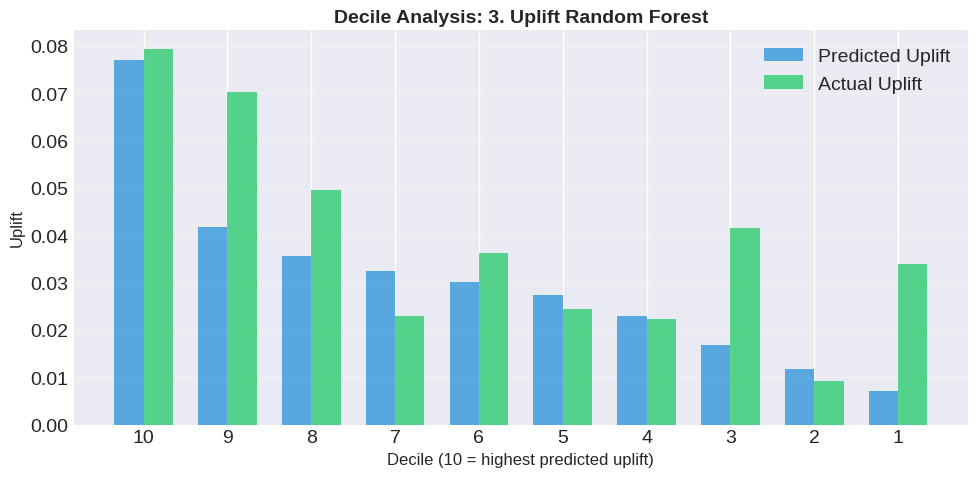

In [156]:
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(decile_stats))
labels = decile_stats.index.astype(int)
width = 0.35

bars1 = ax.bar(x - width/2, decile_stats['Uplift_mean'], width, 
               label='Predicted Uplift', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, decile_stats['Actual_uplift'], width, 
               label='Actual Uplift', color='#2ecc71', alpha=0.8)

ax.set_xlabel('Decile (10 = highest predicted uplift)', fontsize=12)
ax.set_ylabel('Uplift', fontsize=12)
ax.set_title(f'Decile Analysis: {best_model}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('decile_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

Модель ранжирует корректно: топ-дециль (10) даёт максимальный фактический uplift (7.93%), близкий к предсказанному (7.7%)

* Высокая конверсия в нижних децилях (81%) это "уверенные" клиенты, которые купят и без воздействия.
В верхних децилях конверсия ниже (47%), но прирост от воздействия выше — это "убеждаемые"
* Actual uplift не строго монотонен — это нормально для реальных данных, uplift-оценка шумная, но тренд сохраняется
* Рекомендация: таргетировать топ-30% (децили 8-10) для максимального ROI

### Сегментация клиентов (4 сегмента)

In [157]:
# СЕГМЕНТАЦИЯ КЛИЕНТОВ
# Цель: разделить клиентов на 4 сегмента в зависимости от:
#  - базовой вероятности покупки (без воздействия)
#  - эффекта воздействия (uplift)
#
# Сегменты:
# 1) УБЕЖДАЕМЫЕ    — воздействие сильно повышает вероятность покупки
# 2) УВЕРЕННЫЕ     — купят в любом случае, даже без воздействия
# 3) РАВНОДУШНЫЕ   — почти не реагируют на воздействие
# 4) АНТАГОНИСТЫ   — воздействие снижает вероятность покупки

In [158]:
# Вероятность покупки без воздействия (control)
p_control = tm_model.estimator_ctrl.predict_proba(X_test)[:, 1]

# Вероятность покупки при воздействии (treatment)
p_treatment = tm_model.estimator_trmnt.predict_proba(X_test)[:, 1]

# Uplift = эффект воздействия
uplift_for_segments = p_treatment - p_control

# Таблица для сегментации
seg_df = pd.DataFrame({
    "p_control": p_control,
    "p_treatment": p_treatment,
    "uplift": uplift_for_segments,
})

def classify_segment(row, uplift_thr=0.02, prob_thr=0.5) -> str:
    """
    Классификация клиента по сегментам:

    УБЕЖДАЕМЫЕ:   uplift > thr и p_control < prob_thr (реагируют на воздействие)
    УВЕРЕННЫЕ:    p_control >= prob_thr и p_treatment >= prob_thr (купят и так)
    АНТАГОНИСТЫ:  uplift < -thr (воздействие вредит)
    РАВНОДУШНЫЕ:  все остальные (слабый эффект)
    """
    if row["uplift"] > uplift_thr and row["p_control"] < prob_thr:
        return "Убеждаемые"
    elif row["p_control"] >= prob_thr and row["p_treatment"] >= prob_thr:
        return "Уверенные"
    elif row["uplift"] < -uplift_thr:
        return "Антагонисты"
    else:
        return "Равнодушные"


# Применяем сегментацию
seg_df["segment"] = seg_df.apply(classify_segment, axis=1)

# Статистика по сегментам
segment_stats = seg_df["segment"].value_counts().to_frame("Количество")
segment_stats["Доля (%)"] = (segment_stats["Количество"] / len(seg_df) * 100).round(2)

print("\nРаспределение клиентов по сегментам:")
print(segment_stats)


Распределение клиентов по сегментам:
             Количество  Доля (%)
segment                          
Уверенные         39127     65.20
Убеждаемые        13670     22.78
Равнодушные        5259      8.76
Антагонисты        1956      3.26


- Убеждаемые(23%) — ключевая целевая аудитория.
Эти клиенты покупают чаще именно из-за воздействия.

- Уверенные(65%) — купят и без маркетинга.
Воздействие на них — лишние затраты.

- Равнодушные(9%) — почти не реагируют.
Эффект слабый, приоритет низкий.

- Антагонисты(3%) — воздействие вредит.
Их нужно исключать из кампаний.

In [159]:
segment_means = seg_df.groupby("segment")[["p_control", "p_treatment", "uplift"]].mean()
segment_means = segment_means.round(4)

print("\nСредние значения по сегментам:")
print(segment_means)


Средние значения по сегментам:
             p_control  p_treatment  uplift
segment                                    
Антагонисты     0.3670       0.3211 -0.0458
Равнодушные     0.3595       0.3628  0.0033
Убеждаемые      0.3596       0.4235  0.0639
Уверенные       0.7362       0.7594  0.0232


Результаты подтверждают корректность сегментации:
* УБЕЖДАЕМЫЕ (uplift = 6.4%): базовая конверсия 36%, с воздействием 42%
главная целевая аудитория для маркетинга, максимальный ROI

* УВЕРЕННЫЕ (uplift = 2.3%): базовая конверсия уже 74%, с воздействием 76%
можно экономить бюджет, они купят и без воздействия

* РАВНОДУШНЫЕ (uplift = 0.3%): конверсия ~36% почти не меняется
низкий приоритет, эффект минимальный

* АНТАГОНИСТЫ (uplift = -4.6%): конверсия падает с 37% до 32%
исключить из кампаний, воздействие вредит